In [ ]:
!pip install -q librosa soundfile transformers torch accelerate scikit-learn matplotlib seaborn tqdm

import os
import shutil
import glob
from pathlib import Path
from concurrent.futures import ThreadPoolExecutor

import numpy as np
import pandas as pd
import librosa
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

# PyTorch & Transformers
import torch
from transformers import Wav2Vec2Processor, Wav2Vec2Model

# Scikit-Learn
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier

# TensorFlow / Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPooling1D, BatchNormalization


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Copy zip files
shutil.copy("/content/drive/MyDrive/RAV_Speech_Archive.zip", "/content/RAV_Speech.zip")
shutil.copy("/content/drive/MyDrive/RAV_Song_Archive.zip", "/content/RAV_Song.zip")

# Unzip locally
shutil.unpack_archive("/content/RAV_Speech.zip", "/content/RAV_Speech")
shutil.unpack_archive("/content/RAV_Song.zip", "/content/RAV_Song")

print("Dataset is ready!")

Dataset is ready!


In [ ]:
# Define all data in a list
data_sources = [
    "/content/RAV_Speech",
    "/content/RAV_Song"
]

phrase_map = {1: "Kids are talking by the door", 2: "Dogs are sitting by the door"}

emotion_map = {
    1: 'neutral', 2: 'neutral', 3: 'happy', 4: 'sad',
    5: 'angry', 6: 'fear', 7: 'disgust', 8: 'surprise'
}

type_map = {1: 'speech', 2: 'song'}

processed_data = []

# PROCESSING LOOP
for directory in data_sources:
    # Search recursively in all directories
    file_paths = glob.glob(os.path.join(directory, 'Actor_*', '*.wav'))

    for file_path in file_paths:
        filename = os.path.basename(file_path)
        parts = filename.split('.')[0].split('-')

        # RAVDESS filenames have 7 parts
        if len(parts) != 7:
            continue

        # Extract Features
        # Filename structure: 02-01-06-01-02-01-12.wav
        vocal_channel = int(parts[1]) # Song vs Speech
        emotion_code = int(parts[2])
        phrase_code = int(parts[4])
        actor_code = int(parts[6])

        emotion = emotion_map.get(emotion_code, 'unknown')
        phrase = phrase_map.get(phrase_code, 'unknown')
        data_type = type_map.get(vocal_channel, 'unknown')

        # Gender logic: Odd = Male, Even = Female
        gender = "female" if actor_code % 2 == 0 else "male"

        # Build Dictionary
        processed_data.append({
            # combined label
            'labels': f"{gender}_{emotion}",

            # distinct features
            'gender': gender,
            'emotion': emotion,
            'type': data_type,      # track 'speech' vs 'song'
            'phrase': phrase,
            'actor_id': actor_code, # for splitting Train/Test (to avoid data leakage)
            'path': file_path
        })

# DATAFRAME CREATION
RAV_df = pd.DataFrame(processed_data)

# VERIFICATION
print(f"Total files processed: {len(RAV_df)}")
print("\n--- Breakdown by Type and Gender ---")
print(RAV_df.groupby(['type', 'gender']).size())
print("\n--- Breakdown by Emotion ---")
print(RAV_df.groupby(['emotion']).size())

Total files processed: 2452

--- Breakdown by Type and Gender ---
type    gender
song    female    484
        male      528
speech  female    720
        male      720
dtype: int64

--- Breakdown by Emotion ---
emotion
angry       376
disgust     192
fear        376
happy       376
neutral     564
sad         376
surprise    192
dtype: int64


In [ ]:
RAV_df.head()

,labels,gender,emotion,type,phrase,actor_id,path
0,female_fear,female,fear,speech,Kids are talking by the door,24,/content/RAV_Speech/Actor_24/03-01-06-01-01-02...
1,female_fear,female,fear,speech,Kids are talking by the door,24,/content/RAV_Speech/Actor_24/03-01-06-01-01-01...
2,female_surprise,female,surprise,speech,Kids are talking by the door,24,/content/RAV_Speech/Actor_24/03-01-08-01-01-02...
3,female_neutral,female,neutral,speech,Kids are talking by the door,24,/content/RAV_Speech/Actor_24/03-01-02-02-01-01...
4,female_fear,female,fear,speech,Kids are talking by the door,24,/content/RAV_Speech/Actor_24/03-01-06-02-01-01...


In [ ]:
# @title Data Preparation & Feature Extraction

# CONFIGURATION
INCLUDE_TYPES = ['speech']
#INCLUDE_TYPES = ['speech', 'song']

print(f"Filtering Data... keeping {INCLUDE_TYPES}")

# Filter Data
df_active = RAV_df[RAV_df['type'].isin(INCLUDE_TYPES)].copy()
df_active['emotion'] = df_active['emotion'].replace('calm', 'neutral')
df_active['labels'] = df_active['gender'] + '_' + df_active['emotion']

# Ensure actor_id exists
if 'actor_id' not in df_active.columns:
    df_active['actor_id'] = df_active['path'].apply(lambda x: int(x.split('-')[-1].split('.')[0]))

print(f"   Data ready. Total samples: {len(df_active)}")

# HELPER FUNCTIONS
def get_features(y, sr):
    try:
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
        mfcc_delta = librosa.feature.delta(mfcc)
        mfcc_delta2 = librosa.feature.delta(mfcc, order=2)
        combined = np.vstack((mfcc, mfcc_delta, mfcc_delta2))
        if combined.shape[1] < 150:
            pad = 150 - combined.shape[1]
            combined = np.pad(combined, ((0, 0), (0, pad)), mode='constant')
        else:
            combined = combined[:, :150]
        return combined.T
    except: return None

def process_subset(df, augment=False):
    X_seq, X_stat, y_out = [], [], []
    for path, label in zip(df['path'], df['labels']):
        try:
            y, sr = librosa.load(path, sr=22050, duration=3)
            versions = [y]
            if augment:
                noise = 0.005 * np.random.uniform() * np.amax(y)
                versions.append(y + noise * np.random.normal(size=y.shape[0]))
                rate = np.random.uniform(0.9, 1.1)
                y_s = librosa.effects.time_stretch(y=y, rate=rate)
                if len(y_s) > len(y): y_s = y_s[:len(y)]
                else: y_s = np.pad(y_s, (0, len(y)-len(y_s)))
                versions.append(y_s)
            for v in versions:
                feat = get_features(v, sr)
                if feat is not None:
                    X_seq.append(feat)
                    stats = np.concatenate([np.mean(feat,0), np.std(feat,0), np.amax(feat,0), np.amin(feat,0)])
                    X_stat.append(stats)
                    y_out.append(label)
        except: pass
    return np.array(X_seq), np.array(X_stat), np.array(y_out)

# EXECUTION
master_data = {}
print("\n Running Pipeline...")

for g in ['male', 'female']:
    print(f"\n Processing: {g.upper()}")
    subset = df_active[df_active['gender'] == g].copy()

    # Split
    train = subset[subset['actor_id'] <= 18]
    val   = subset[subset['actor_id'].isin([19, 20])]
    test  = subset[subset['actor_id'] >= 21]

    # Extract
    X_train_seq, X_train_stat, y_train = process_subset(train, augment=True)
    X_val_seq,   X_val_stat,   y_val   = process_subset(val,   augment=False)
    X_test_seq,  X_test_stat,  y_test  = process_subset(test,  augment=False)

    # Encode Labels
    lb = LabelEncoder()
    all_labels = np.concatenate([y_train, y_val, y_test])
    lb.fit(all_labels)

    # Scale Data
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train_stat)

    # STORE EVERYTHING (Including Encoder & Scaler)
    master_data[g] = {
        'X_train_seq': X_train_seq, 'X_train_stat': X_train_s, 'y_train': lb.transform(y_train),
        'X_val_seq':   X_val_seq,   'X_val_stat':   scaler.transform(X_val_stat),   'y_val':   lb.transform(y_val),
        'X_test_seq':  X_test_seq,  'X_test_stat':  scaler.transform(X_test_stat),  'y_test':  lb.transform(y_test),
        'classes': lb.classes_,
        'scaler': scaler,  #
        'encoder': lb      #
    }

print("\n Data Ready.")

Filtering Data... keeping ['speech']
   Data ready. Total samples: 1440

 Running Pipeline...

 Processing: MALE

 Processing: FEMALE

 Data Ready.


In [ ]:
# @title Train Gender Classifier

print("Training Gender Gatekeeper")

# Prepare Data
X_gate_train = np.vstack([master_data['male']['X_train_stat'], master_data['female']['X_train_stat']])
# Labels: 1 for Male, 0 for Female
y_gate_train = np.concatenate([np.ones(len(master_data['male']['y_train'])), np.zeros(len(master_data['female']['y_train']))])

# Train the Random Forest
gatekeeper = RandomForestClassifier(n_estimators=100, random_state=42)
gatekeeper.fit(X_gate_train, y_gate_train)

# Verify
X_gate_test = np.vstack([master_data['male']['X_test_stat'], master_data['female']['X_test_stat']])
y_gate_test = np.concatenate([np.ones(len(master_data['male']['y_test'])), np.zeros(len(master_data['female']['y_test']))])
acc = accuracy_score(y_gate_test, gatekeeper.predict(X_gate_test))

print(f"Classifier Trained. Gender Detection Accuracy: {acc:.2%}")

Training Gender Gatekeeper
Classifier Trained. Gender Detection Accuracy: 100.00%


Training Male & Female Baselines...
2Running Blind Evaluation
Baseline Accuracy: 13.33%


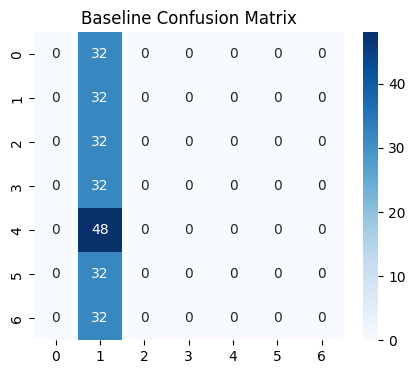

In [ ]:
# @title Model A: Baseline

# TRAIN MODELS
print("Training Male & Female Baselines...")
m_male = DummyClassifier(strategy="stratified", random_state=42)
m_male.fit(master_data['male']['X_train_stat'], master_data['male']['y_train'])

m_female = DummyClassifier(strategy="stratified", random_state=42)
m_female.fit(master_data['female']['X_train_stat'], master_data['female']['y_train'])

# BLIND EVALUATION
print("2Running Blind Evaluation")

# A. Construct Blind Test Set (Stats)
X_test = np.concatenate([master_data['male']['X_test_stat'], master_data['female']['X_test_stat']])
y_true = np.concatenate([master_data['male']['y_test'], master_data['female']['y_test']])

# Gatekeeper Routing
gender_preds = gatekeeper.predict(X_test) # 1=Male, 0=Female

# Prediction Loop
final_preds = []
for i in range(len(X_test)):
    sample = X_test[i].reshape(1, -1)
    # Route: If Gatekeeper says Male (1), use Male model, else Female
    model = m_male if gender_preds[i] == 1 else m_female
    final_preds.append(model.predict(sample)[0])

# RESULTS
acc = accuracy_score(y_true, final_preds)
print(f"Baseline Accuracy: {acc:.2%}")

plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_true, final_preds), annot=True, fmt='d', cmap='Blues')
plt.title("Baseline Confusion Matrix")
plt.show()

Training Male & Female Baselines (Mode)
Running Blind Evaluation
Baseline Accuracy: 20.00%


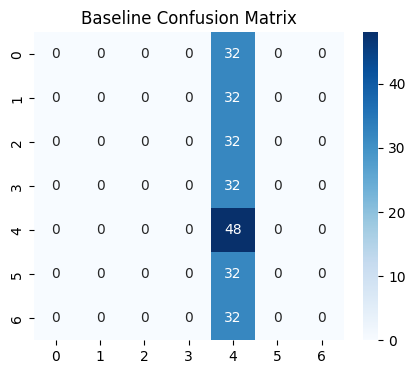

In [ ]:
# @title Model B: Baseline (Mode)

# TRAIN MODELS

# "Statistical Baseline". It ignores the input data
# and simply checks which emotion appears most often in the training set.
print("Training Male & Female Baselines (Mode)")

m_male = DummyClassifier(strategy="most_frequent", random_state=42)
m_male.fit(master_data['male']['X_train_stat'], master_data['male']['y_train'])

m_female = DummyClassifier(strategy="most_frequent", random_state=42)
m_female.fit(master_data['female']['X_train_stat'], master_data['female']['y_train'])

# BLIND EVALUATION ---
print("Running Blind Evaluation")

# A. Construct Blind Test Set
X_test = np.concatenate([master_data['male']['X_test_stat'], master_data['female']['X_test_stat']])
y_true = np.concatenate([master_data['male']['y_test'], master_data['female']['y_test']])

# Gatekeeper Routing
gender_preds = gatekeeper.predict(X_test)

# Prediction Loop
final_preds = []
for i in range(len(X_test)):
    sample = X_test[i].reshape(1, -1)
    model = m_male if gender_preds[i] == 1 else m_female
    final_preds.append(model.predict(sample)[0])

# RESULTS
acc = accuracy_score(y_true, final_preds)
print(f"Baseline Accuracy: {acc:.2%}")

# The Confusion Matrix looks like a solid vertical line
# because it only predicts ONE label per gender!
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_true, final_preds), annot=True, fmt='d', cmap='Blues')
plt.title("Baseline Confusion Matrix")
plt.show()

Training Male & Female Random Forests...
Running Blind Evaluation
Random Forest Accuracy: 48.33%


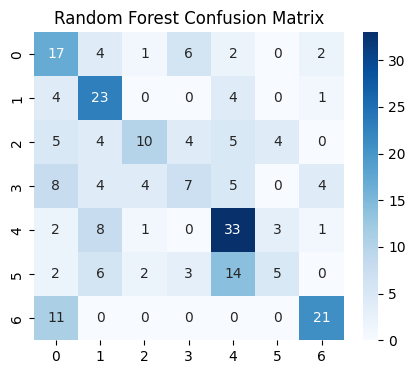

In [ ]:
# @title Model C: Simple ML (Random Forest)

# TRAIN MODELS
print("Training Male & Female Random Forests...")
rf_male = RandomForestClassifier(n_estimators=100, random_state=42)
rf_male.fit(master_data['male']['X_train_stat'], master_data['male']['y_train'])

rf_female = RandomForestClassifier(n_estimators=100, random_state=42)
rf_female.fit(master_data['female']['X_train_stat'], master_data['female']['y_train'])

# BLIND EVALUATION
print("Running Blind Evaluation")

# Construct Blind Test Set (Stats)
X_test = np.concatenate([master_data['male']['X_test_stat'], master_data['female']['X_test_stat']])
y_true = np.concatenate([master_data['male']['y_test'], master_data['female']['y_test']])

# Gatekeeper Routing
gender_preds = gatekeeper.predict(X_test)

# Prediction Loop
final_preds = []
for i in range(len(X_test)):
    sample = X_test[i].reshape(1, -1)
    model = rf_male if gender_preds[i] == 1 else rf_female
    final_preds.append(model.predict(sample)[0])

# RESULTS
acc_rf = accuracy_score(y_true, final_preds)  #
print(f"Random Forest Accuracy: {acc_rf:.2%}")

plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_true, final_preds), annot=True, fmt='d', cmap='Blues')
plt.title("Random Forest Confusion Matrix")
plt.show()

Training Male & Female CNNs...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Running Blind Evaluation...
CNN Accuracy: 45.83%


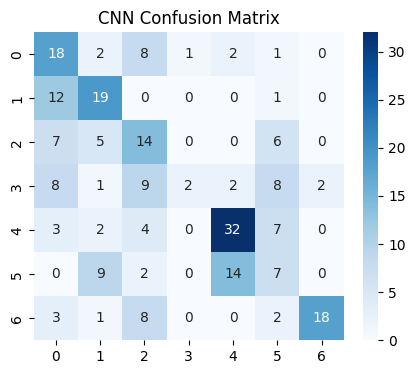

In [ ]:
# @title Model D: CNN

# Define Architecture
def create_cnn(input_shape, num_classes):
    model = Sequential([
        Conv1D(64, 3, activation='relu', input_shape=input_shape),
        MaxPooling1D(2),
        BatchNormalization(),
        Conv1D(128, 3, activation='relu'),
        MaxPooling1D(2),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# TRAIN MODELS
print("Training Male & Female CNNs...")
# Get shapes from data
input_shape = master_data['male']['X_train_seq'].shape[1:]
num_classes = len(master_data['male']['classes'])

cnn_male = create_cnn(input_shape, num_classes)
cnn_male.fit(master_data['male']['X_train_seq'], master_data['male']['y_train'], epochs=15, verbose=0)

cnn_female = create_cnn(input_shape, num_classes)
cnn_female.fit(master_data['female']['X_train_seq'], master_data['female']['y_train'], epochs=15, verbose=0)

# BLIND EVALUATION
print("Running Blind Evaluation...")

# A. Construct Blind Test Set (SEQUENCE DATA)
X_test_seq = np.concatenate([master_data['male']['X_test_seq'], master_data['female']['X_test_seq']])
# We still need STATS for the Gatekeeper!
X_test_stat = np.concatenate([master_data['male']['X_test_stat'], master_data['female']['X_test_stat']])
y_true = np.concatenate([master_data['male']['y_test'], master_data['female']['y_test']])

# Gatekeeper Routing
gender_preds = gatekeeper.predict(X_test_stat)

# Prediction Loop
final_preds = []
for i in range(len(X_test_seq)):
    # Reshape for Keras (1, time, feat)
    sample = np.expand_dims(X_test_seq[i], axis=0)

    model = cnn_male if gender_preds[i] == 1 else cnn_female

    # Get prediction (argmax for class index)
    pred_probs = model.predict(sample, verbose=0)
    final_preds.append(np.argmax(pred_probs))

# RESULTS
acc_cnn = accuracy_score(y_true, final_preds) # <--- CHANGED THIS NAME
print(f"CNN Accuracy: {acc_cnn:.2%}")

plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_true, final_preds), annot=True, fmt='d', cmap='Blues')
plt.title("CNN Confusion Matrix")
plt.show()

Training Male & Female VGG Models...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Running Blind Evaluation...
VGG Accuracy: 42.08%


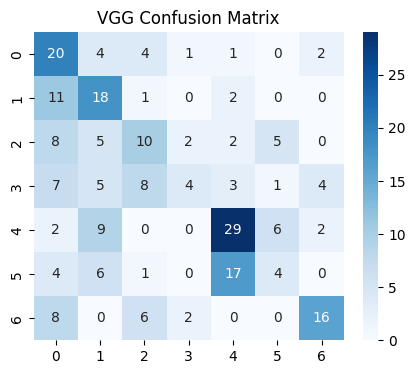

In [ ]:
# @title Model E: VGG (Deep 1D CNN)

def create_vgg_style(input_shape, num_classes):
    model = Sequential([
        # Block 1
        Conv1D(32, 3, activation='relu', padding='same', input_shape=input_shape),
        Conv1D(32, 3, activation='relu', padding='same'),
        MaxPooling1D(2),
        # Block 2
        Conv1D(64, 3, activation='relu', padding='same'),
        Conv1D(64, 3, activation='relu', padding='same'),
        MaxPooling1D(2),
        # Block 3
        Conv1D(128, 3, activation='relu', padding='same'),
        MaxPooling1D(2),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.4),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# TRAIN MODELS
print("Training Male & Female VGG Models...")
input_shape = master_data['male']['X_train_seq'].shape[1:]
num_classes = len(master_data['male']['classes'])

vgg_male = create_vgg_style(input_shape, num_classes)
vgg_male.fit(master_data['male']['X_train_seq'], master_data['male']['y_train'], epochs=15, verbose=0)

vgg_female = create_vgg_style(input_shape, num_classes)
vgg_female.fit(master_data['female']['X_train_seq'], master_data['female']['y_train'], epochs=15, verbose=0)

# BLIND EVALUATION
print("Running Blind Evaluation...")

# A. Data Prep
X_test_seq = np.concatenate([master_data['male']['X_test_seq'], master_data['female']['X_test_seq']])
X_test_stat = np.concatenate([master_data['male']['X_test_stat'], master_data['female']['X_test_stat']])
y_true = np.concatenate([master_data['male']['y_test'], master_data['female']['y_test']])

# Gatekeeper Routing (Needs Stats)
gender_preds = gatekeeper.predict(X_test_stat)

# Prediction Loop (Needs Seq)
final_preds = []
for i in range(len(X_test_seq)):
    sample = np.expand_dims(X_test_seq[i], axis=0)
    model = vgg_male if gender_preds[i] == 1 else vgg_female
    final_preds.append(np.argmax(model.predict(sample, verbose=0)))

# RESULTS
acc_vgg = accuracy_score(y_true, final_preds)
print(f"VGG Accuracy: {acc_vgg:.2%}")

plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_true, final_preds), annot=True, fmt='d', cmap='Blues')
plt.title("VGG Confusion Matrix")
plt.show()

In [ ]:
# @title Model F: SOTA Wav2Vec 2.0

# SETUP
print("Loading Emotion-Tuned Wav2Vec Model...")
model_name = "audeering/wav2vec2-large-robust-12-ft-emotion-msp-dim"
processor = Wav2Vec2Processor.from_pretrained(model_name)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
w2v_model = Wav2Vec2Model.from_pretrained(model_name).to(device)

def get_w2v_embedding(path):
    try:
        y, sr = librosa.load(path, sr=16000, duration=3)
        inputs = processor(y, sampling_rate=16000, return_tensors="pt", padding=True)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        with torch.no_grad():
            outputs = w2v_model(**inputs)
        return torch.mean(outputs.last_hidden_state, dim=1).cpu().numpy()[0]
    except: return np.zeros(1024)

# EXTRACT EMBEDDINGS
print("\n Extracting SOTA Embeddings...")
w2v_data = {}

# specific scaler for Wav2Vec embeddings (distinct from the MFCC scaler)
scaler_w2v = StandardScaler()
all_train_embeddings = [] # Temp list to fit the scaler later

for g in ['male', 'female']:
    w2v_data[g] = {'X_train': [], 'y_train': [], 'X_test': [], 'y_test': []}
    subset = df_active[df_active['gender'] == g]

    # Extract X (Embeddings)
    for path in tqdm(subset[subset['actor_id'] <= 18]['path'], desc=f"{g} Train"):
        emb = get_w2v_embedding(path)
        w2v_data[g]['X_train'].append(emb)
        all_train_embeddings.append(emb) # Collect for scaler

    for path in tqdm(subset[subset['actor_id'] >= 21]['path'], desc=f"{g} Test"):
        w2v_data[g]['X_test'].append(get_w2v_embedding(path))

    le = master_data[g]['encoder']
    w2v_data[g]['y_train'] = le.transform(subset[subset['actor_id'] <= 18]['labels'])
    w2v_data[g]['y_test'] = le.transform(subset[subset['actor_id'] >= 21]['labels'])

    # Convert to Numpy
    w2v_data[g]['X_train'] = np.array(w2v_data[g]['X_train'])
    w2v_data[g]['X_test'] = np.array(w2v_data[g]['X_test'])

# SCALING (Crucial for SVM) ---
print("\n Scaling Embeddings...")
# Fit scaler on ALL training data (Male + Female combined)
scaler_w2v.fit(all_train_embeddings)

# Apply transform
for g in ['male', 'female']:
    w2v_data[g]['X_train'] = scaler_w2v.transform(w2v_data[g]['X_train'])
    w2v_data[g]['X_test'] = scaler_w2v.transform(w2v_data[g]['X_test'])

# TRAIN SVM HEAD
print("Training SVMs...")
svm_male = SVC(kernel='rbf', C=10, gamma='scale', probability=True, random_state=42)
svm_male.fit(w2v_data['male']['X_train'], w2v_data['male']['y_train'])

svm_female = SVC(kernel='rbf', C=10, gamma='scale', probability=True, random_state=42)
svm_female.fit(w2v_data['female']['X_train'], w2v_data['female']['y_train'])

# EVALUATE
X_test = np.concatenate([w2v_data['male']['X_test'], w2v_data['female']['X_test']])
y_true = np.concatenate([w2v_data['male']['y_test'], w2v_data['female']['y_test']])
# Gatekeeper checks stats data
gender_preds = gatekeeper.predict(np.concatenate([master_data['male']['X_test_stat'], master_data['female']['X_test_stat']]))

final_preds = []
for i in range(len(X_test)):
    sample = X_test[i].reshape(1, -1)
    model = svm_male if gender_preds[i] == 1 else svm_female
    final_preds.append(model.predict(sample)[0])

acc_w2v_sota = accuracy_score(y_true, final_preds)
print(f"\n Model H (Wav2Vec+SVM) Accuracy: {acc_w2v_sota:.2%}")

Loading Emotion-Tuned Wav2Vec Model...

 Extracting SOTA Embeddings...


male Train:   0%|          | 0/540 [00:00<?, ?it/s]

male Test:   0%|          | 0/120 [00:00<?, ?it/s]

female Train:   0%|          | 0/540 [00:00<?, ?it/s]

female Test:   0%|          | 0/120 [00:00<?, ?it/s]


 Scaling Embeddings...
Training SVMs...

 Model H (Wav2Vec+SVM) Accuracy: 68.75%


2. Add Model I (The Hybrid)
This code is now much simpler because it relies on the SVMs we just trained above.

In [ ]:
# @title Model G: The Hybrid Ensemble (Wav2Vec + CNN)

print(" Running Hybrid Ensemble Inference")

# Setup Data Pointers
# Wav2Vec Data (Scaled)
X_w2v = np.concatenate([w2v_data['male']['X_test'], w2v_data['female']['X_test']])
# CNN Data (Sequence)
X_seq = np.concatenate([master_data['male']['X_test_seq'], master_data['female']['X_test_seq']])
# True Labels
y_true = np.concatenate([w2v_data['male']['y_test'], w2v_data['female']['y_test']])

# Gatekeeper Decision
gender_preds = gatekeeper.predict(np.concatenate([master_data['male']['X_test_stat'], master_data['female']['X_test_stat']]))

# Inference Loop
final_preds_hybrid = []

for i in range(len(y_true)):
    is_male = gender_preds[i] == 1

    # Get Wav2Vec Probability (SVM)
    model_svm = svm_male if is_male else svm_female
    prob_w2v = model_svm.predict_proba(X_w2v[i].reshape(1, -1))[0]

    # Get CNN Probability
    model_cnn = cnn_male if is_male else cnn_female # Assumes Cell 4 ran
    prob_cnn = model_cnn.predict(np.expand_dims(X_seq[i], axis=0), verbose=0)[0]

    # Weighted Mix (0.6 / 0.4)
    avg_prob = (prob_w2v * 0.6) + (prob_cnn * 0.4)
    final_preds_hybrid.append(np.argmax(avg_prob))

# Score
acc_hybrid = accuracy_score(y_true, final_preds_hybrid)
print(f"Model I (Hybrid) Accuracy: {acc_hybrid:.2%}")

 Running Hybrid Ensemble Inference
Model I (Hybrid) Accuracy: 63.33%


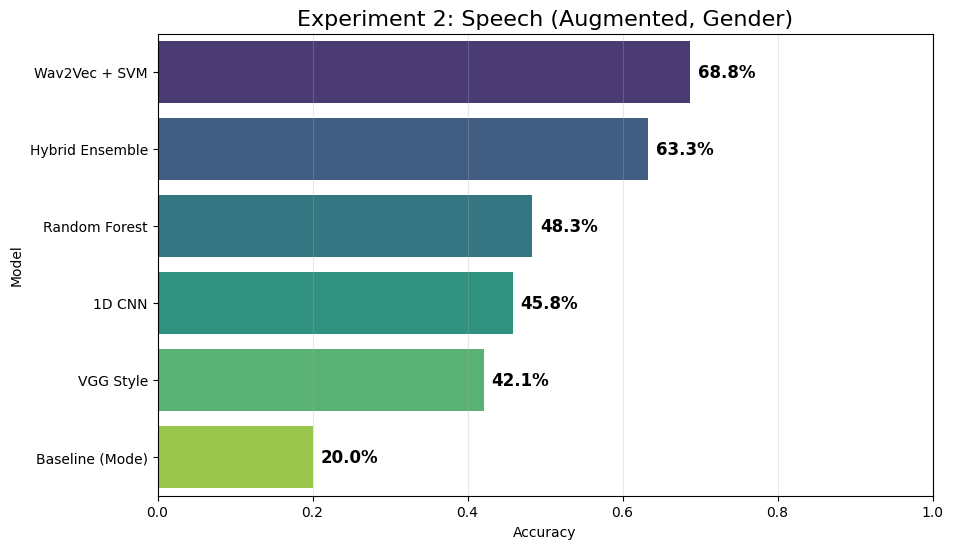


 The Winning Model is: Wav2Vec + SVM with 68.75% accuracy.


In [ ]:
# @title Final Results

# Scores from previous cells
scores = {
    'Baseline (Mode)': locals().get('acc', 0),           #
    'Random Forest': locals().get('acc_rf', 0),          #
    '1D CNN': locals().get('acc_cnn', 0),                #
    'VGG Style': locals().get('acc_vgg', 0),             #
    'Wav2Vec + SVM': locals().get('acc_w2v_sota', 0),    #
    'Hybrid Ensemble': locals().get('acc_hybrid', 0)     #
}

# Create DataFrame
df_results = pd.DataFrame(list(scores.items()), columns=['Model', 'Accuracy'])
df_results = df_results.sort_values('Accuracy', ascending=False).reset_index(drop=True)

# Identify Winner
best_model_name = df_results.iloc[0]['Model']
best_acc = df_results.iloc[0]['Accuracy']

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Accuracy', y='Model', data=df_results, palette='viridis', hue='Model', legend=False)
plt.xlim(0, 1.0)

# Add text labels
for i, v in enumerate(df_results['Accuracy']):
    plt.text(v + 0.01, i, f"{v:.1%}", va='center', fontweight='bold', fontsize=12)

plt.title(f'Experiment 2: Speech (Augmented, Gender)', fontsize=16)
#plt.title(f'Final Project Results\nWinner: {best_model_name}', fontsize=16)

plt.grid(axis='x', alpha=0.3)
plt.show()

print(f"\n The Winning Model is: {best_model_name} with {best_acc:.2%} accuracy.")

In [ ]:
print(df_results)

             Model  Accuracy
0    Wav2Vec + SVM  0.687500
1  Hybrid Ensemble  0.633333
2    Random Forest  0.483333
3           1D CNN  0.458333
4        VGG Style  0.420833
5  Baseline (Mode)  0.200000
